# Untargeted Adversarial Attack with Incomplete CIFAR10

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, Softmax, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools
import seaborn as sns
import pickle

## Deep Convolutional Network for CIFAR10


In [2]:
mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['axes.grid'] = False
path = '/content/drive/MyDrive/Work/Baylor/Research/ad_ex_incomplete/' #your directory's path
#cifar_set1 = '/content/drive/MyDrive/Work/Baylor/Research/cifar-10-batches-py/data_batch_1'
learning_rate = 0.01
batch_size = 2000
epochs = 20

In [4]:
def predict_class(model, input):
  pred = model.predict(input)
  class_pred = []
  for i in pred:
    ans = tf.argmax(i)
    class_pred.append(ans)
  return tf.convert_to_tensor(class_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
opt = Adam(learning_rate=learning_rate)

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input)
batch1 = BatchNormalization()(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch1)
pool1 = MaxPooling2D((2, 2))(conv2)
batch2 = BatchNormalization()(pool1)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch2)
batch3 = BatchNormalization()(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
pool2 = MaxPooling2D((2, 2))(conv4)
batch4 = BatchNormalization()(pool2)
conv5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch4)
batch5 = BatchNormalization()(conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)
pool3 = MaxPooling2D((2,2))(conv6)
batch6 = BatchNormalization()(pool3)
drop1 = Dropout(0.4)(batch6)

flat1 = Flatten()(drop1)
dense1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
batch7 = BatchNormalization()(dense1)
drop2 = Dropout(0.4)(batch7)
dense2 = Dense(10)(drop2)
output = Softmax()(dense2)

z_cifar_classifier = Model(input, dense2, name='z_cifar_classifier')

cifar_classifier = Model(input, output, name='cifar_classifier')

z_cifar_classifier.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
cifar_classifier.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/255
x_test = x_test/255
y_train = tf.reshape(y_train, (y_train.shape[0]))
y_test = tf.reshape(y_test, (y_test.shape[0]))
y_train_oh = tf.one_hot(y_train, 10)
y_test_oh = tf.one_hot(y_test, 10)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10,  
                              min_delta=1e-4, mode='min')

stop_alg = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

#Cross validation training
n_trains = x_train.shape[0]
n_val = 5
n_sub_trains = n_trains // n_val
x_cross_val = []
y_cross_val = []
for i in range(n_val):
  x_cross_val.append(x_train[i*n_sub_trains:(i+1)*n_sub_trains])
  y_cross_val.append(y_train_oh[i*n_sub_trains:(i+1)*n_sub_trains])
for i in range(epochs):
  print('Epoch: ' + str(i+1))
  x_train_turn = []
  y_train_turn = []
  for j in range(n_val):
    if (j != i%n_val):
      if (len(x_train_turn) == 0):
        x_train_turn = x_cross_val[j]
        y_train_turn = y_cross_val[j]
      else:
        x_train_turn = tf.concat([x_train_turn, x_cross_val[j]], axis = 0)
        y_train_turn = tf.concat([y_train_turn, y_cross_val[j]], axis = 0)
  x_val = x_cross_val[i%n_val]
  y_val = y_cross_val[i%n_val]
  cifar_classifier.fit(x_train_turn,y_train_turn,batch_size=batch_size,validation_data=(x_val,y_val),
                     verbose=1,epochs=1, callbacks=[reduce_lr, stop_alg])
  cifar_classifier.save_weights(path + 'cifar_weights')
cifar_classifier.save_weights(path + 'cifar_weights')

Epoch: 1
20/20 [==============================] - 159s 8s/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 0.0989 - val_accuracy: 0.9698
Epoch: 2
20/20 [==============================] - 159s 8s/step - loss: 0.0450 - accuracy: 0.9851 - val_loss: 0.0322 - val_accuracy: 0.9877
Epoch: 3
20/20 [==============================] - 163s 8s/step - loss: 0.0406 - accuracy: 0.9855 - val_loss: 0.1004 - val_accuracy: 0.9697
Epoch: 4
20/20 [==============================] - 159s 8s/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.0543 - val_accuracy: 0.9803
Epoch: 5
20/20 [==============================] - 162s 8s/step - loss: 0.0451 - accuracy: 0.9846 - val_loss: 0.0302 - val_accuracy: 0.9899
Epoch: 6
20/20 [==============================] - 160s 8s/step - loss: 0.0481 - accuracy: 0.9833 - val_loss: 0.0792 - val_accuracy: 0.9732
Epoch: 7
20/20 [==============================] - 160s 8s/step - loss: 0.0455 - accuracy: 0.9844 - val_loss: 0.0886 - val_accuracy: 0.9706
Epoch: 8
20/20 [===========

In [7]:
cifar_classifier.load_weights(path+'cifar_weights')

In [ ]:
pred = cifar_classifier.predict(x_test)
cce = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
class_pred = predict_class(cifar_classifier, x_test)

Loss: 1.29
Accuracy: 78.73%
BER: 0.79


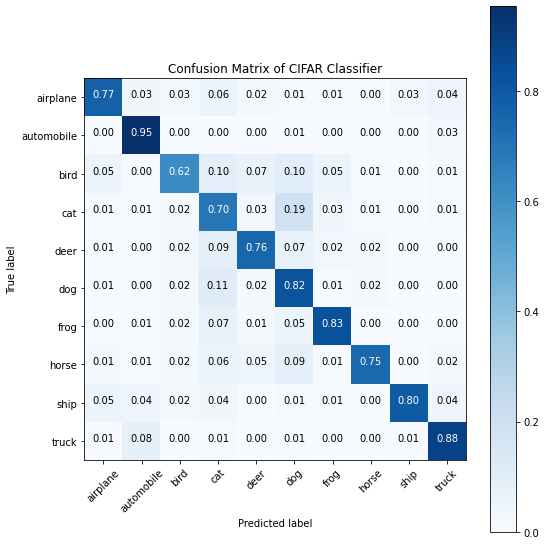

In [ ]:
print('Loss: {:.2f}'.format(cce(y_test_oh, pred).numpy()))
print('Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_test, class_pred)*100))
print('BER: {:.2f}'.format(metrics.balanced_accuracy_score(y_test, class_pred)))
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
mpl.rcParams['figure.figsize'] = (8, 8)
plot_confusion_matrix(metrics.confusion_matrix(y_test, class_pred),classes,title='Confusion Matrix of CIFAR Classifier',normalize=True)
mpl.rcParams['figure.figsize'] = (4, 4)

## Declare test automobile

In [8]:
inx_test = 6
image = x_test[inx_test]
w = 32
h = 32
ch = 3

correct_inx = y_test[inx_test]
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
image_probs = cifar_classifier.predict(tf.reshape(image, (1,h,w,ch)))
label = tf.one_hot(correct_inx, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [9]:
def get_class_confidence(input_image):
  input_image = tf.reshape(input_image, (1,h,w,ch))
  class_pred = predict_class(cifar_classifier, input_image)[0]
  conf = cifar_classifier.predict(input_image)[0][class_pred]
  return class_pred, conf

## Experiment

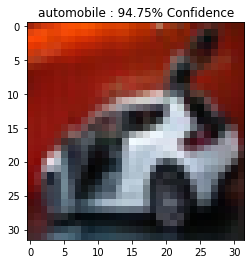

In [ ]:
plt.figure()
plt.imshow(image) # To change [-1, 1] to [0,1]
image_class, class_confidence = get_class_confidence(image)
plt.title('{} : {:.2f}% Confidence'.format(classes[image_class], class_confidence*100))
plt.show()

### Define Attacks 

In [10]:
#loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = tf.keras.losses.MeanSquaredError()

def get_max_and_index(input):
  max = 0
  inx_i = 0
  inx_j = 0
  inx_k = 0
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        if (input[0][i][j][k] >= max):
          inx_i = i
          inx_j = j
          inx_k = k
          max = input[0][i][j][k]
  return max, inx_i, inx_j, inx_k

def convert_s_map(grad, inx_tgt, targeted=False):
  n_classes = len(grad)
  s = np.zeros((1,h,w,ch))
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        sum = 0
        for t in range(n_classes):
          if (t != inx_tgt):
            sum += grad[t][i][j][k]
        if ((not targeted) and grad[inx_tgt][i][j][k] <= 0 and sum >= grad[inx_tgt][i][j][k]):
          s[0][i][j][k] = tf.abs(grad[inx_tgt][i][j][k]) * sum
        elif (targeted and grad[inx_tgt][i][j][k] >= 0 and sum <= 0):
          s[0][i][j][k] = grad[inx_tgt][i][j][k] * tf.abs(sum)
  return tf.cast(tf.convert_to_tensor(s), tf.float32)

def saliency_map(input_image, masked = None):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  gradient = []
  n_classes = len(cifar_classifier.predict(input_image)[0])
  for i in range(n_classes):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = z_cifar_classifier(input_image) 
      pred_inx = prediction[0][i]
    gradient.append((tf.cast(tape.gradient(pred_inx, input_image), tf.float32)*masked)[0])
  return gradient
  
def fgsm(input_image, input_label, epsilon, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.cast(tf.reshape(input_image, (1,h,w,ch)), tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = cifar_classifier(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.cast(tf.sign(gradient), tf.float32)
  if (not targeted):
    return tf.clip_by_value(tf.reshape(input_image + tf.cast(epsilon*signed_grad*masked, tf.float32), (h,w,ch)), 0,1)
  return tf.clip_by_value(tf.reshape(input_image - epsilon*signed_grad*masked, (h,w,ch)), 0,1)

def igsm(input_image, input_label, inx_tgt, max_iter, step_size, epsilon, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.cast(tf.reshape(input_image, (1,h,w,ch)), tf.float32 )
  adv = input_image
  i = 0
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  
  while(i < max_iter and (((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
    with tf.GradientTape() as tape:
      tape.watch(adv)
      prediction = cifar_classifier(adv)
      loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, adv)
    signed_grad = tf.cast(tf.sign(gradient), tf.float32)
    if (not targeted):
      adv = adv + step_size*signed_grad*masked
    else:
      adv = adv - step_size*signed_grad*masked
    adv = tf.clip_by_value(adv,input_image-epsilon,input_image+epsilon)
    adv = tf.clip_by_value(adv,0,1)
    new_label, new_confidence = get_class_confidence(adv)
    i += 1
  return tf.reshape(adv, (h,w,ch))

def jsma(input_image, inx_tgt, max_iter, step_size, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.cast(tf.reshape(input_image, (1,h,w,ch)), tf.float32)
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  adv = input_image
  altered = np.zeros(input_image.shape)
  count = 0
  while (np.sum(altered) <= 0.05*w*h*ch and count < max_iter and ((not targeted and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
    grad = saliency_map(adv, masked)
    s = convert_s_map(grad, inx_tgt, targeted=targeted)
    max, inx_i, inx_j, inx_k = get_max_and_index(s)
    if (max == 0):
      return tf.reshape(adv, (h,w,ch)), np.sum(altered)
    altered[0][inx_i][inx_j][inx_k] = 1
    tmp = np.zeros((1,h,w,ch))
    tmp[0][inx_i][inx_j][inx_k] = step_size
    tmp = tf.cast(tf.constant(tmp), tf.float32)
    adv = adv + tmp
    adv = tf.clip_by_value(adv,0,1)  

    if (adv[0][inx_i][inx_j][inx_k] == 0 or adv[0][inx_i][inx_j][inx_k] == 1):
      tmp = np.ones((1,h,w,ch))
      tmp[0][inx_i][inx_j][inx_k] = 0
      tmp = tf.constant(tmp)
      masked = masked * tf.cast(tmp,tf.float32)
    new_label, new_confidence = get_class_confidence(adv)
    #print(str(inx_i) + ", " + str(inx_j) + ", " + str(inx_k) + ", " + str(adv[0][inx_i][inx_j][inx_k]) + ", " + str(new_confidence) + " " + str(count) + ' ' + str(new_label))
    count += 1
  return tf.reshape(adv, (h,w,ch)), np.sum(altered)

def loss_for_cw(model, x, inx_tgt, targeted=False, conf=0):
  re_x = tf.reshape(x,(1,h,w,ch))
  pred = model(re_x)  
  max = -9999
  for i in range(pred.shape[1]):
    if (i != inx_tgt and pred[0][i] >= max):
      max = pred[0][i]
  if (targeted):
    return tf.maximum(max - pred[0][inx_tgt], conf)
  else:
    return tf.maximum(pred[0][inx_tgt] - max, conf)

def cw(input_image, inx_tgt, max_iter, step_size, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  input_image = tf.cast(input_image, tf.float32)
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)    
  w_ = tf.atanh(input_image*2 - 1)
  c = 0.01
  loss1 = 15  
  while ((((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt)) and c <= 100):
    i = 0
    while (i < max_iter and (((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
      with tf.GradientTape() as tape:
        tape.watch(w_)
        adv = tf.cast((tf.tanh(w_) + 1.0)/2.0, tf.float32)
        adv = input_image + (adv - input_image)*masked
        loss1 = tf.norm((adv-input_image)*masked)        
        loss2 = loss_for_cw(z_cifar_classifier, adv, inx_tgt, targeted=targeted)
        loss = loss1 + c*loss2
      gradient = tape.gradient(loss, w_)
      w_ = w_ - step_size*gradient
      adv = tf.cast((tf.tanh(w_) + 1.0)/2.0, tf.float32)
      adv = input_image + (adv - input_image)*masked
      new_label, new_confidence = get_class_confidence(adv)
      #print('new label: {}, new confidence: {}, loss1: {}, loss2: {}'.format(new_label, new_confidence, loss1, loss2))
      i += 1
    c *= 2
  return adv, tf.norm(adv - input_image), c

### Experiment on automobile

In [11]:
def display_images(image, description):
  prediction = cifar_classifier.predict(tf.reshape(image, (1,h,w,ch)))
  label, confidence = get_class_confidence(image)  
  plt.figure()
  plt.imshow(tf.reshape(image, (h,w,ch))) # To change [-1, 1] to [0,1]
  print('{} \n Pred={} : {:.2f}% Confidence \n {} : {:.2f}% Confidence'.format(description,
                                                   classes[label], confidence*100, classes[correct_inx], prediction[0][correct_inx]*100))
  plt.show()

In [12]:
epsilons = []
i = 0
while (i <= 0.51):
  epsilons.append(i)
  i += 0.02
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
conf_fgsm = []
conf_igsm = []
conf_jsma = []
conf_cw = []

conf_fgsm_top = []
conf_igsm_top = []
conf_jsma_top = []
conf_cw_top = []

conf_fgsm_bottom = []
conf_igsm_bottom = []
conf_jsma_bottom = []
conf_cw_bottom = []


other_conf_fgsm = []
other_conf_igsm = []
other_conf_jsma = []
other_conf_cw = []

other_conf_fgsm_top = []
other_conf_igsm_top = []
other_conf_jsma_top = []
other_conf_cw_top = []

other_conf_fgsm_bottom = []
other_conf_igsm_bottom = []
other_conf_jsma_bottom = []
other_conf_cw_bottom = []

#### Complete image



##### FGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


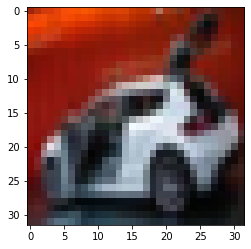

Epsilon = 0.020 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


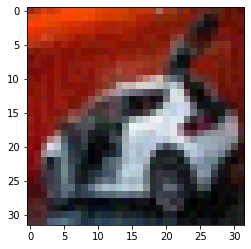

Epsilon = 0.040 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


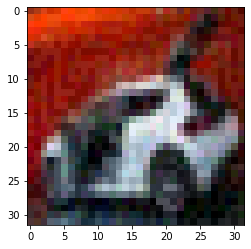

Epsilon = 0.060 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


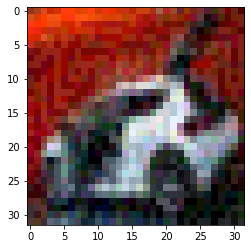

Epsilon = 0.080 
 Pred=truck : 98.63% Confidence 
 automobile : 0.00% Confidence


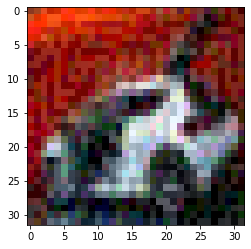

Epsilon = 0.100 
 Pred=cat : 70.55% Confidence 
 automobile : 0.01% Confidence


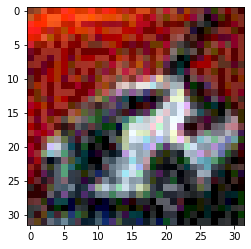

Epsilon = 0.120 
 Pred=cat : 86.10% Confidence 
 automobile : 0.05% Confidence


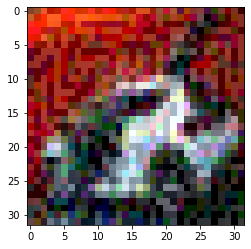

Epsilon = 0.140 
 Pred=cat : 48.71% Confidence 
 automobile : 0.65% Confidence


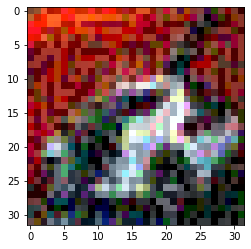

Epsilon = 0.160 
 Pred=frog : 96.18% Confidence 
 automobile : 0.48% Confidence


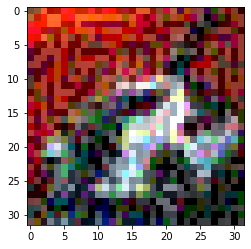

Epsilon = 0.180 
 Pred=frog : 99.78% Confidence 
 automobile : 0.11% Confidence


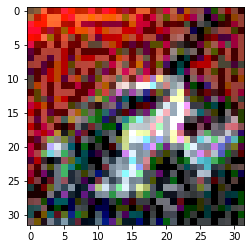

Epsilon = 0.200 
 Pred=frog : 99.96% Confidence 
 automobile : 0.03% Confidence


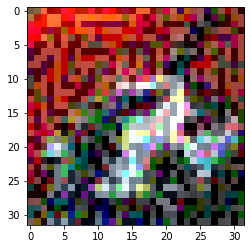

Epsilon = 0.220 
 Pred=frog : 99.99% Confidence 
 automobile : 0.01% Confidence


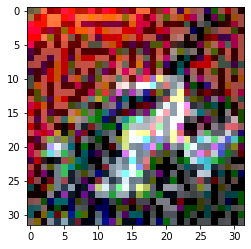

Epsilon = 0.240 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


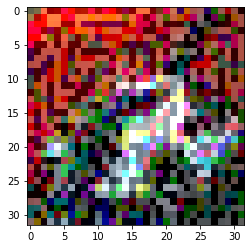

Epsilon = 0.260 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


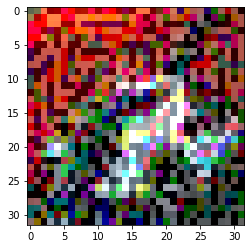

Epsilon = 0.280 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


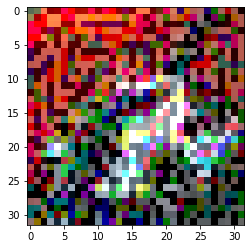

Epsilon = 0.300 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


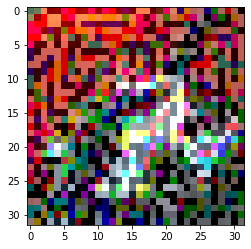

Epsilon = 0.320 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


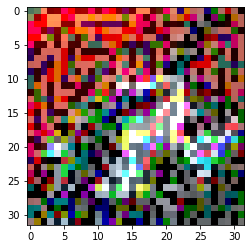

Epsilon = 0.340 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


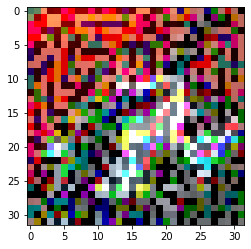

Epsilon = 0.360 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


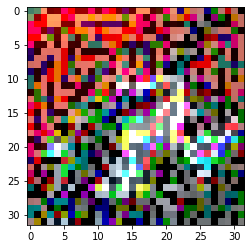

Epsilon = 0.380 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


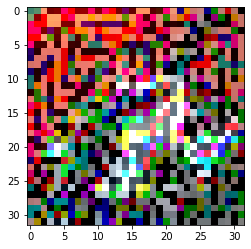

Epsilon = 0.400 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


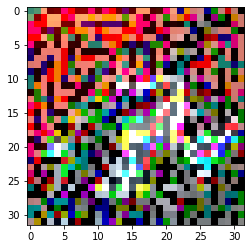

Epsilon = 0.420 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


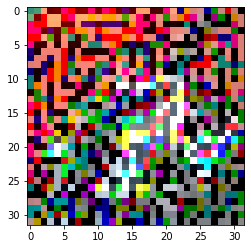

Epsilon = 0.440 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


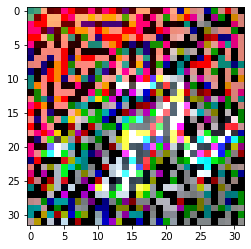

Epsilon = 0.460 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


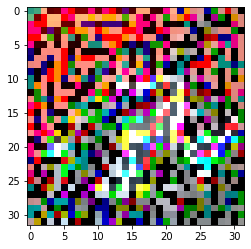

Epsilon = 0.480 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


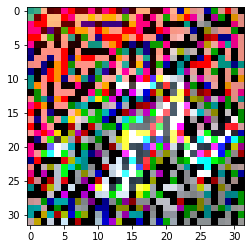

Epsilon = 0.500 
 Pred=frog : 100.00% Confidence 
 automobile : 0.00% Confidence


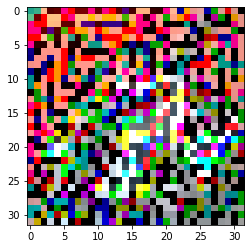

In [13]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps)
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


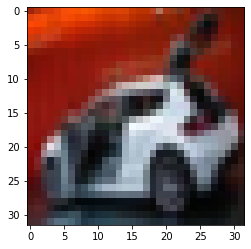

Epsilon = 0.020 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


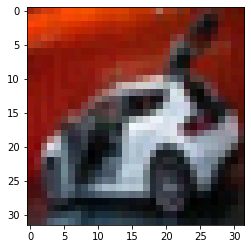

Epsilon = 0.040 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


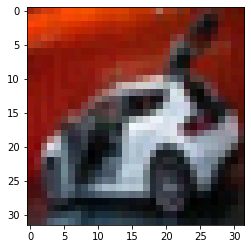

Epsilon = 0.060 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


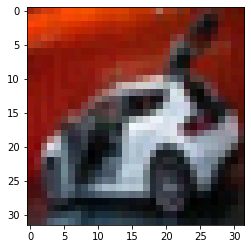

Epsilon = 0.080 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


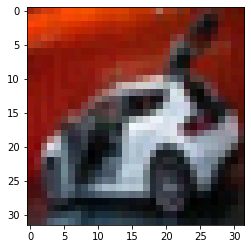

Epsilon = 0.100 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


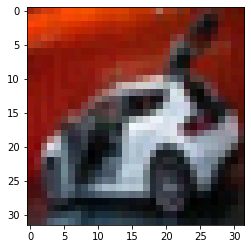

Epsilon = 0.120 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


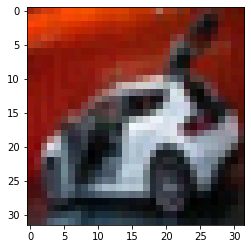

Epsilon = 0.140 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


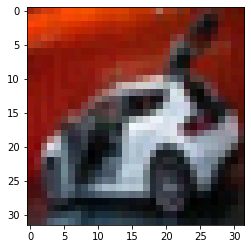

Epsilon = 0.160 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


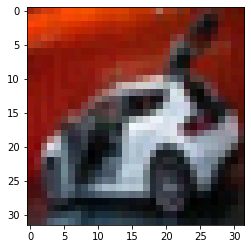

Epsilon = 0.180 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


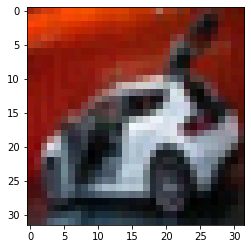

Epsilon = 0.200 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


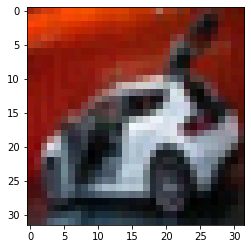

Epsilon = 0.220 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


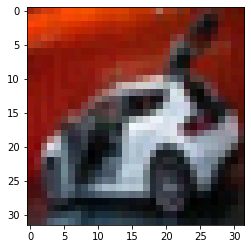

Epsilon = 0.240 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


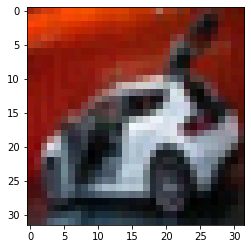

Epsilon = 0.260 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


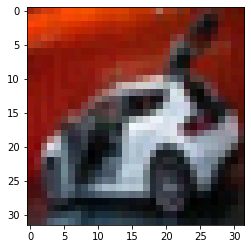

Epsilon = 0.280 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


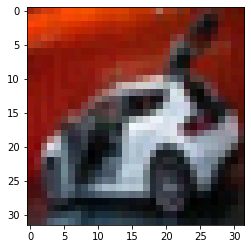

Epsilon = 0.300 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


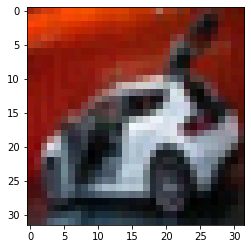

Epsilon = 0.320 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


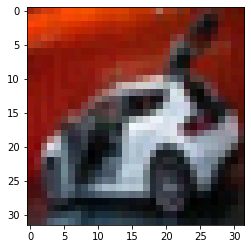

Epsilon = 0.340 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


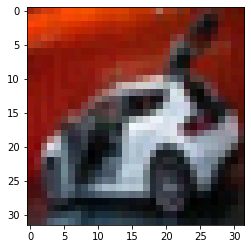

Epsilon = 0.360 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


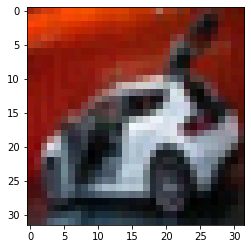

Epsilon = 0.380 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


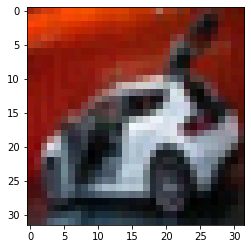

Epsilon = 0.400 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


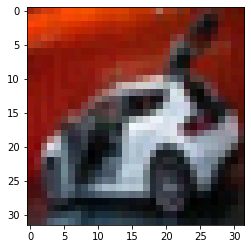

Epsilon = 0.420 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


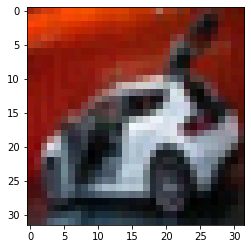

Epsilon = 0.440 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


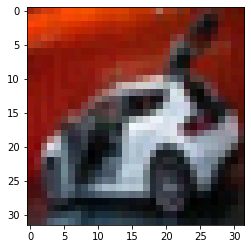

Epsilon = 0.460 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


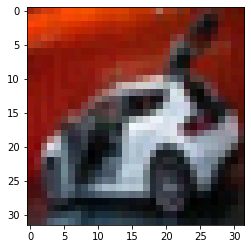

Epsilon = 0.480 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


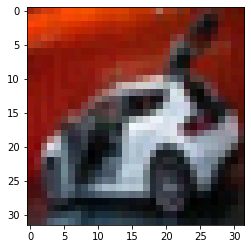

Epsilon = 0.500 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


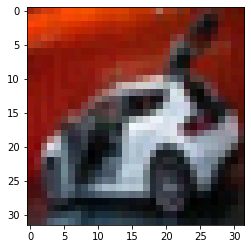

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 1, eps//0.01, 0.01, eps)
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 0.03905950486660004, c = 0.04 
 Pred=truck : 50.52% Confidence 
 automobile : 49.48% Confidence


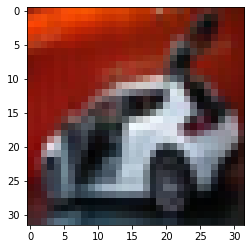

In [ ]:
adv, eps, c  = cw(image, 1, 50, 0.1)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

JSMA: Epsilion = 7.0 
 Pred=truck : 51.97% Confidence 
 automobile : 41.85% Confidence


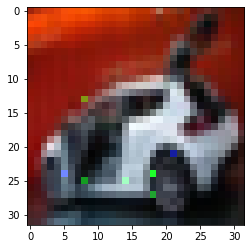

In [ ]:
adv, eps  = jsma(image, 1, 400, 0.5)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Top part of image

In [14]:
amount_perturbation = 16
top_padding = 0
#top_padding = 20
bottom_padding = h-(amount_perturbation+top_padding)

masked_top = tf.concat([tf.zeros((1,top_padding,w,ch)), tf.ones((1,amount_perturbation,w,ch))], 1)
masked_top = tf.concat([masked_top, tf.zeros((1,bottom_padding,w,ch))], 1)

##### FGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


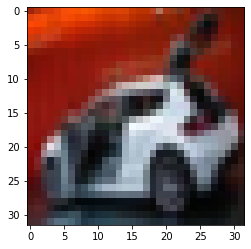

Epsilon = 0.020 
 Pred=truck : 97.52% Confidence 
 automobile : 2.48% Confidence


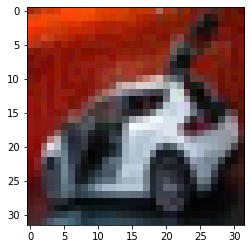

Epsilon = 0.040 
 Pred=truck : 91.59% Confidence 
 automobile : 8.41% Confidence


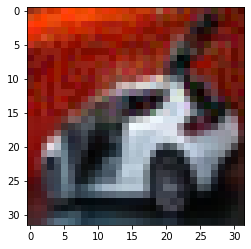

Epsilon = 0.060 
 Pred=truck : 82.25% Confidence 
 automobile : 17.75% Confidence


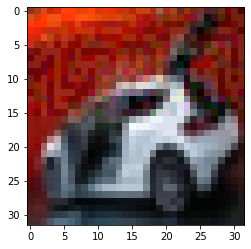

Epsilon = 0.080 
 Pred=truck : 91.28% Confidence 
 automobile : 8.72% Confidence


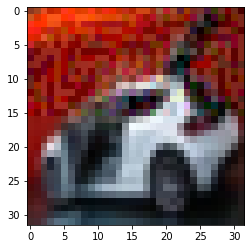

Epsilon = 0.100 
 Pred=truck : 90.29% Confidence 
 automobile : 9.71% Confidence


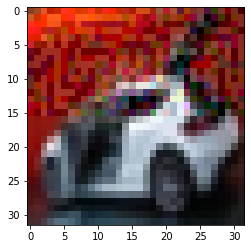

Epsilon = 0.120 
 Pred=truck : 75.40% Confidence 
 automobile : 24.60% Confidence


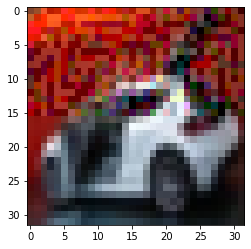

Epsilon = 0.140 
 Pred=automobile : 67.51% Confidence 
 automobile : 67.51% Confidence


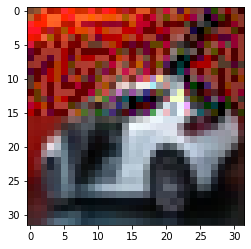

Epsilon = 0.160 
 Pred=automobile : 92.16% Confidence 
 automobile : 92.16% Confidence


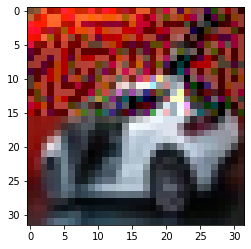

Epsilon = 0.180 
 Pred=automobile : 98.08% Confidence 
 automobile : 98.08% Confidence


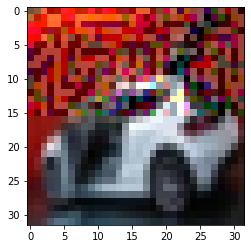

Epsilon = 0.200 
 Pred=automobile : 99.26% Confidence 
 automobile : 99.26% Confidence


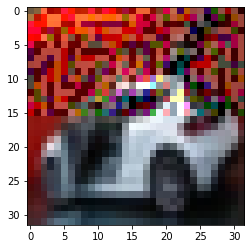

Epsilon = 0.220 
 Pred=automobile : 99.50% Confidence 
 automobile : 99.50% Confidence


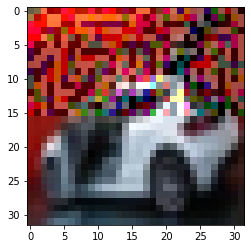

Epsilon = 0.240 
 Pred=automobile : 99.63% Confidence 
 automobile : 99.63% Confidence


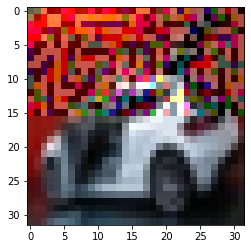

Epsilon = 0.260 
 Pred=automobile : 99.87% Confidence 
 automobile : 99.87% Confidence


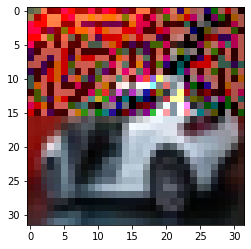

Epsilon = 0.280 
 Pred=automobile : 99.97% Confidence 
 automobile : 99.97% Confidence


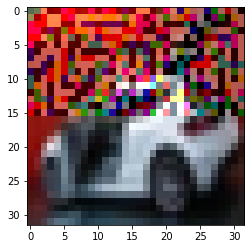

Epsilon = 0.300 
 Pred=automobile : 99.99% Confidence 
 automobile : 99.99% Confidence


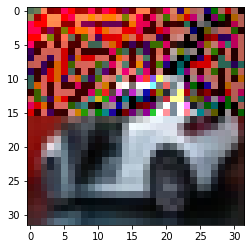

Epsilon = 0.320 
 Pred=automobile : 99.99% Confidence 
 automobile : 99.99% Confidence


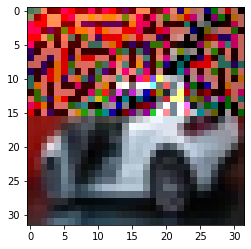

Epsilon = 0.340 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


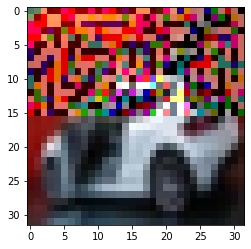

Epsilon = 0.360 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


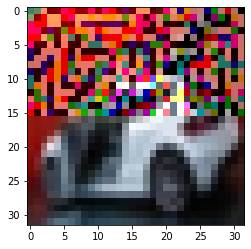

Epsilon = 0.380 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


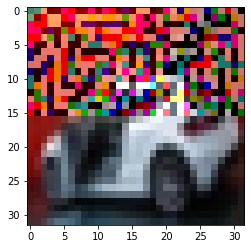

Epsilon = 0.400 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


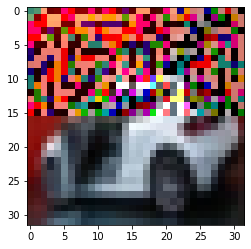

Epsilon = 0.420 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


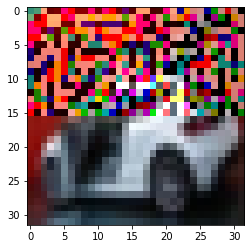

Epsilon = 0.440 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


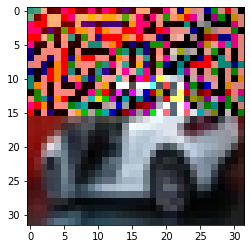

Epsilon = 0.460 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


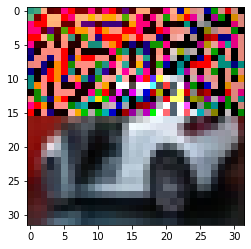

Epsilon = 0.480 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


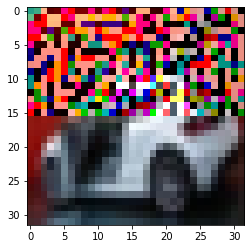

Epsilon = 0.500 
 Pred=automobile : 100.00% Confidence 
 automobile : 100.00% Confidence


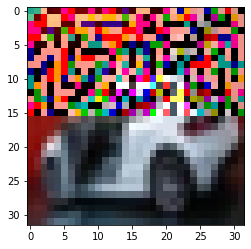

In [15]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps,masked_top)
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm_top.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm_top.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


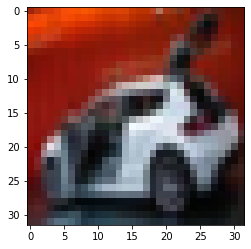

Epsilon = 0.020 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


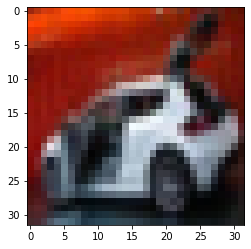

Epsilon = 0.040 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


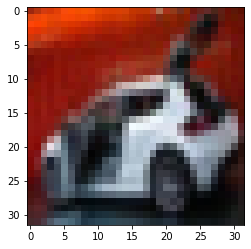

Epsilon = 0.060 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


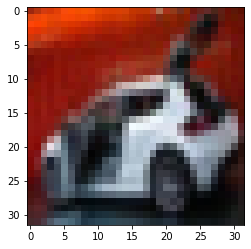

Epsilon = 0.080 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


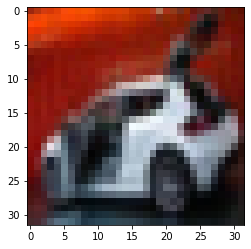

Epsilon = 0.100 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


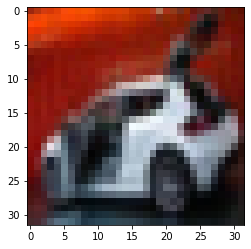

Epsilon = 0.120 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


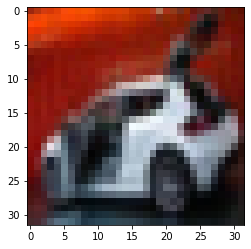

Epsilon = 0.140 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


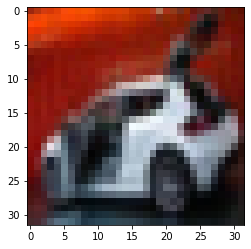

Epsilon = 0.160 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


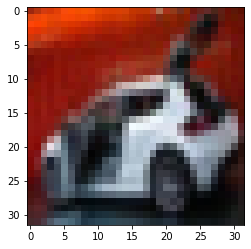

Epsilon = 0.180 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


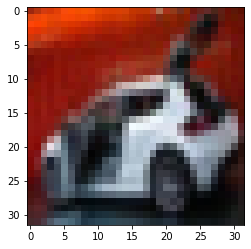

Epsilon = 0.200 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


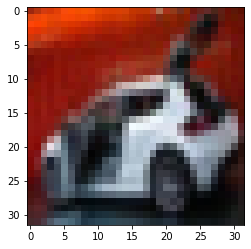

Epsilon = 0.220 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


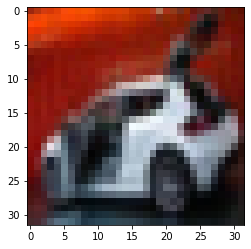

Epsilon = 0.240 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


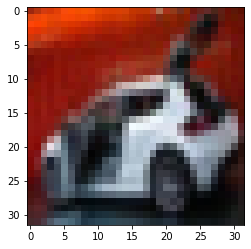

Epsilon = 0.260 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


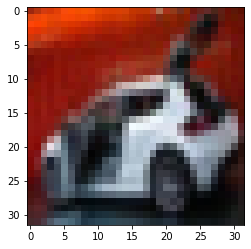

Epsilon = 0.280 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


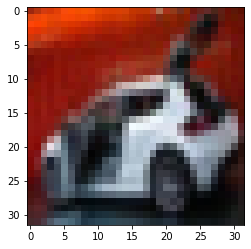

Epsilon = 0.300 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


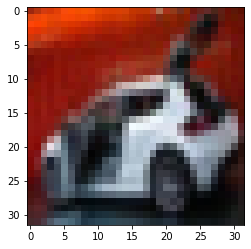

Epsilon = 0.320 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


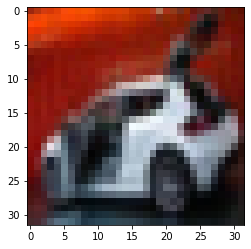

Epsilon = 0.340 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


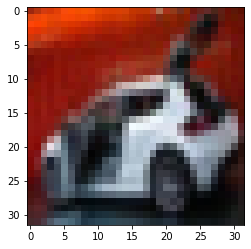

Epsilon = 0.360 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


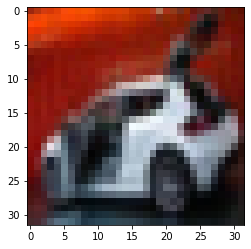

Epsilon = 0.380 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


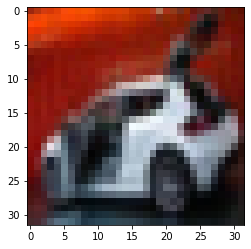

Epsilon = 0.400 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


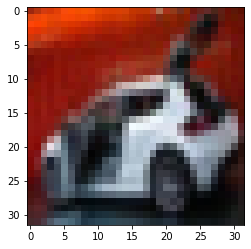

Epsilon = 0.420 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


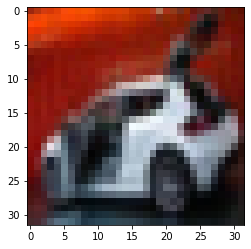

Epsilon = 0.440 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


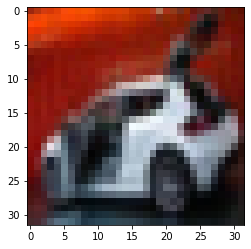

Epsilon = 0.460 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


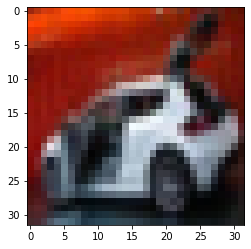

Epsilon = 0.480 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


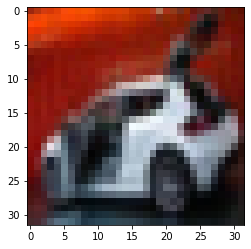

Epsilon = 0.500 
 Pred=truck : 93.19% Confidence 
 automobile : 6.81% Confidence


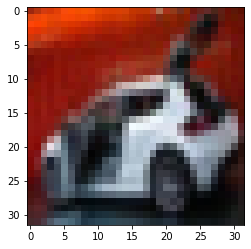

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 1, eps//0.01, 0.01, eps, masked_top)
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm_top.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm_top.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 0.08757296204566956, c = 0.08 
 Pred=truck : 50.03% Confidence 
 automobile : 49.97% Confidence


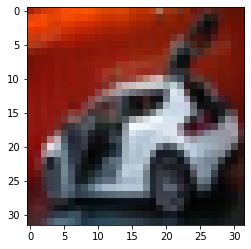

In [ ]:
adv, eps, c  = cw(image, 1, 50, 0.1, masked=masked_top)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

JSMA: Epsilion = 21.0 
 Pred=truck : 59.70% Confidence 
 automobile : 40.29% Confidence


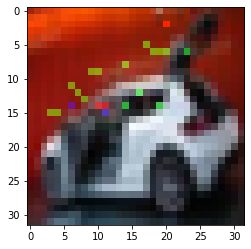

In [ ]:
adv, eps  = jsma(image, 1, 400, 0.5, masked=masked_top)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Bottom

In [16]:
amount_perturbation = 16
top_padding = 16
bottom_padding = h-(amount_perturbation+top_padding)

masked_bottom = tf.concat([tf.zeros((1,top_padding,w,ch)), tf.ones((1,amount_perturbation,w,ch))], 1)
masked_bottom = tf.concat([masked_bottom, tf.zeros((1,bottom_padding,w,ch))], 1)

###### FGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


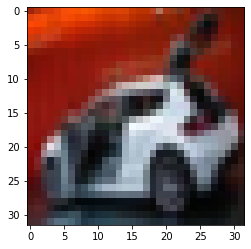

Epsilon = 0.020 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


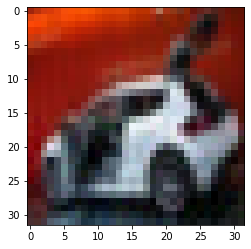

Epsilon = 0.040 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


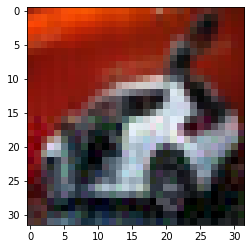

Epsilon = 0.060 
 Pred=truck : 100.00% Confidence 
 automobile : 0.00% Confidence


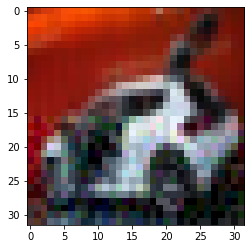

Epsilon = 0.080 
 Pred=truck : 99.74% Confidence 
 automobile : 0.00% Confidence


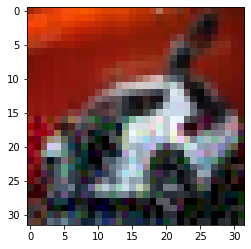

Epsilon = 0.100 
 Pred=truck : 75.94% Confidence 
 automobile : 0.01% Confidence


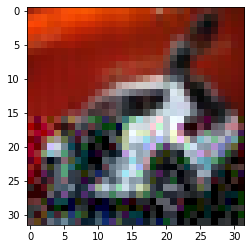

Epsilon = 0.120 
 Pred=frog : 96.24% Confidence 
 automobile : 0.01% Confidence


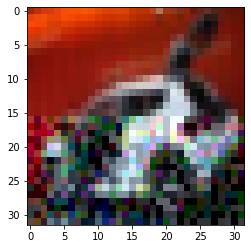

Epsilon = 0.140 
 Pred=frog : 99.64% Confidence 
 automobile : 0.01% Confidence


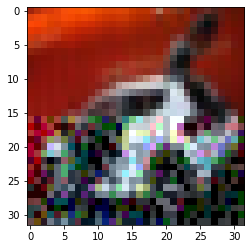

Epsilon = 0.160 
 Pred=frog : 99.93% Confidence 
 automobile : 0.01% Confidence


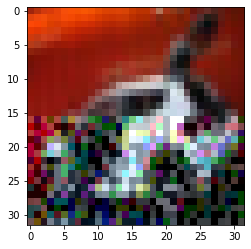

Epsilon = 0.180 
 Pred=frog : 99.95% Confidence 
 automobile : 0.03% Confidence


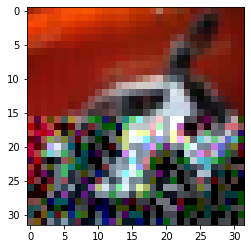

Epsilon = 0.200 
 Pred=frog : 99.94% Confidence 
 automobile : 0.05% Confidence


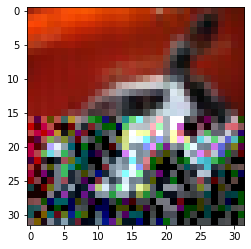

Epsilon = 0.220 
 Pred=frog : 99.92% Confidence 
 automobile : 0.08% Confidence


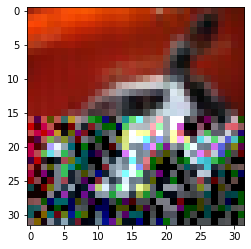

Epsilon = 0.240 
 Pred=frog : 99.82% Confidence 
 automobile : 0.18% Confidence


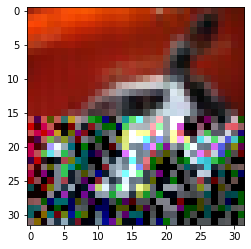

Epsilon = 0.260 
 Pred=frog : 99.56% Confidence 
 automobile : 0.44% Confidence


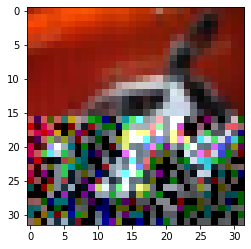

Epsilon = 0.280 
 Pred=frog : 99.19% Confidence 
 automobile : 0.81% Confidence


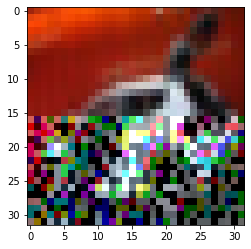

Epsilon = 0.300 
 Pred=frog : 98.50% Confidence 
 automobile : 1.50% Confidence


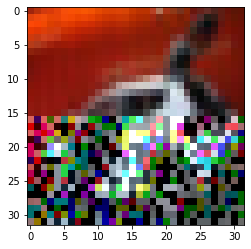

Epsilon = 0.320 
 Pred=frog : 97.89% Confidence 
 automobile : 2.11% Confidence


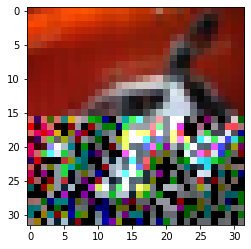

Epsilon = 0.340 
 Pred=frog : 97.38% Confidence 
 automobile : 2.61% Confidence


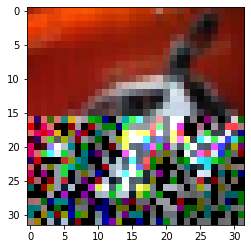

Epsilon = 0.360 
 Pred=frog : 96.93% Confidence 
 automobile : 3.07% Confidence


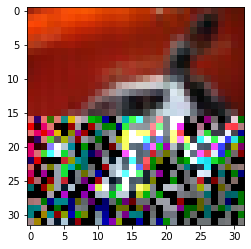

Epsilon = 0.380 
 Pred=frog : 95.84% Confidence 
 automobile : 4.16% Confidence


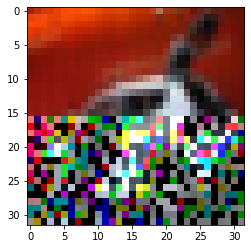

Epsilon = 0.400 
 Pred=frog : 94.19% Confidence 
 automobile : 5.81% Confidence


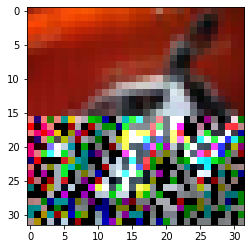

Epsilon = 0.420 
 Pred=frog : 93.52% Confidence 
 automobile : 6.48% Confidence


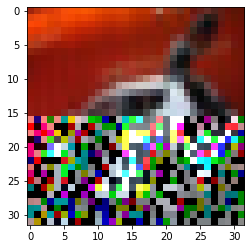

Epsilon = 0.440 
 Pred=frog : 92.54% Confidence 
 automobile : 7.46% Confidence


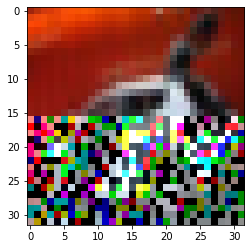

Epsilon = 0.460 
 Pred=frog : 92.97% Confidence 
 automobile : 7.03% Confidence


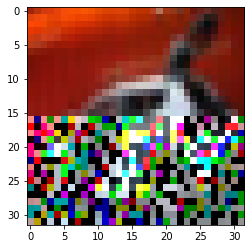

Epsilon = 0.480 
 Pred=frog : 92.70% Confidence 
 automobile : 7.30% Confidence


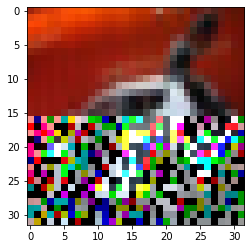

Epsilon = 0.500 
 Pred=frog : 90.49% Confidence 
 automobile : 9.50% Confidence


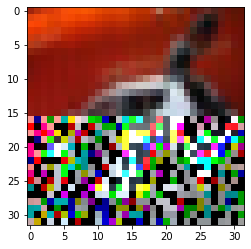

In [17]:
for i, eps in enumerate(epsilons):
  adv = fgsm(image, label, eps,masked_bottom)  
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_fgsm_bottom.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_fgsm_bottom.append(max)
  display_images(adv, descriptions[i])

##### IGSM

Input 
 Pred=automobile : 94.75% Confidence 
 automobile : 94.75% Confidence


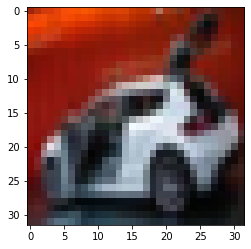

Epsilon = 0.020 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


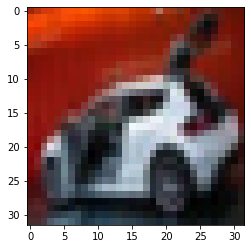

Epsilon = 0.040 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


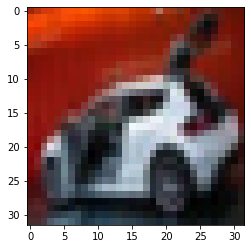

Epsilon = 0.060 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


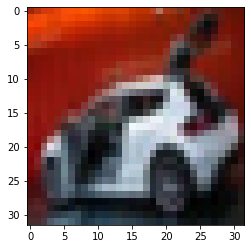

Epsilon = 0.080 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


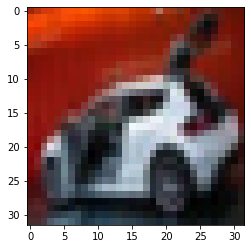

Epsilon = 0.100 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


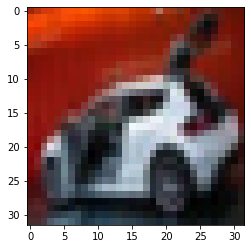

Epsilon = 0.120 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


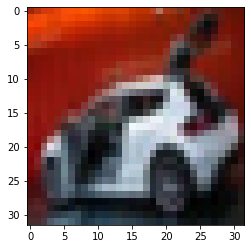

Epsilon = 0.140 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


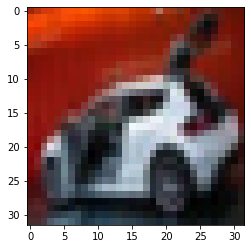

Epsilon = 0.160 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


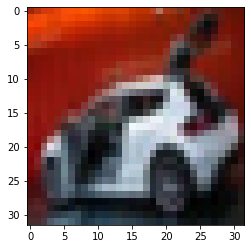

Epsilon = 0.180 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


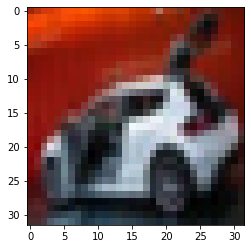

Epsilon = 0.200 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


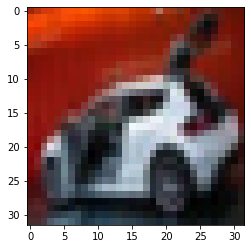

Epsilon = 0.220 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


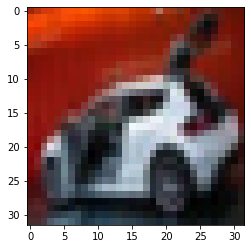

Epsilon = 0.240 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


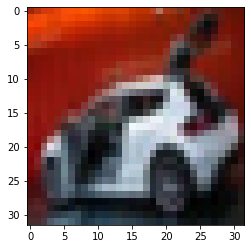

Epsilon = 0.260 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


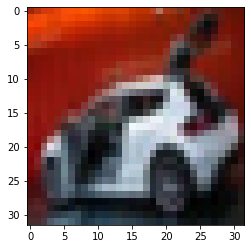

Epsilon = 0.280 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


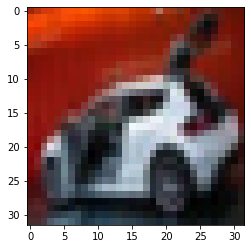

Epsilon = 0.300 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


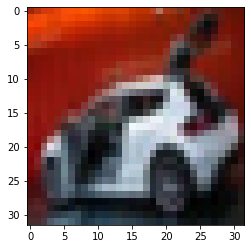

Epsilon = 0.320 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


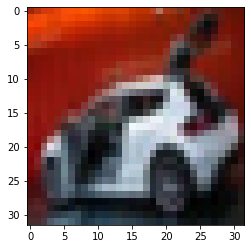

Epsilon = 0.340 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


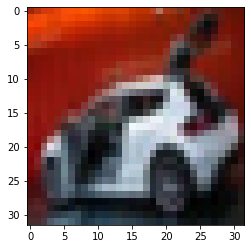

Epsilon = 0.360 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


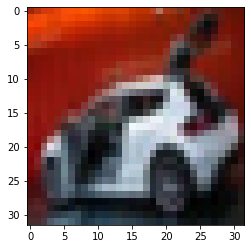

Epsilon = 0.380 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


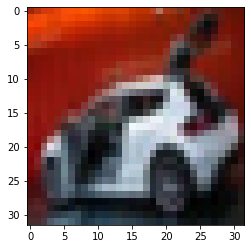

Epsilon = 0.400 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


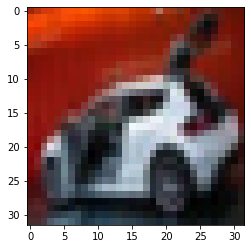

Epsilon = 0.420 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


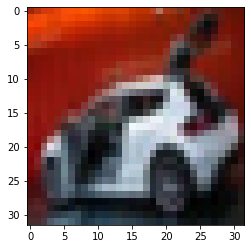

Epsilon = 0.440 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


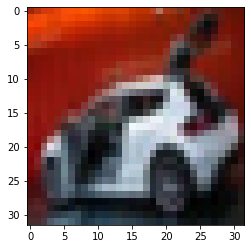

Epsilon = 0.460 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


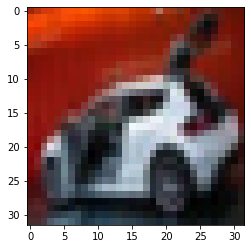

Epsilon = 0.480 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


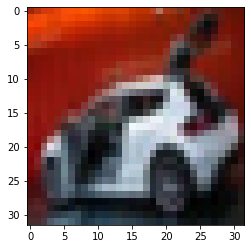

Epsilon = 0.500 
 Pred=truck : 99.98% Confidence 
 automobile : 0.02% Confidence


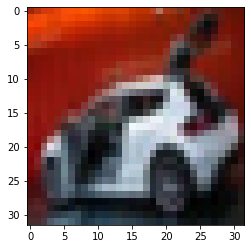

In [ ]:
for i, eps in enumerate(epsilons):
  adv = igsm(image, label, 1, eps//0.01, 0.01, eps, masked_bottom)
  pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
  conf_igsm_bottom.append(pred[0][correct_inx])
  max = 0
  for j in range(pred.shape[1]):
    if(j != correct_inx and pred[0][j] >= max):
      max = pred[0][j]
  other_conf_igsm_bottom.append(max)
  display_images(adv, descriptions[i])

##### CW Attack

CW: Epsilion = 0.04502786695957184, c = 0.04 
 Pred=truck : 53.72% Confidence 
 automobile : 46.28% Confidence


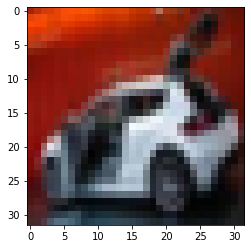

In [ ]:
adv, eps, c  = cw(image, 1, 50, 0.1, masked=masked_bottom)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'CW: Epsilion = {}, c = {}'.format(eps, c))

##### JSMA

JSMA: Epsilion = 12.0 
 Pred=truck : 54.53% Confidence 
 automobile : 41.91% Confidence


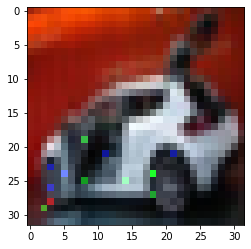

In [ ]:
adv, eps  = jsma(image, 1, 400, 0.5, masked=masked_bottom)
pred = cifar_classifier.predict(tf.reshape(adv, (1,h,w,ch)))
display_images(adv, 'JSMA: Epsilion = {}'.format(eps))

#### Save variables

In [ ]:
with open(path + 'cifar_objs_l_inf.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([conf_fgsm, conf_igsm, conf_fgsm_top,conf_igsm_top, 
                 conf_fgsm_bottom, conf_igsm_bottom,
                 other_conf_fgsm, other_conf_igsm, other_conf_fgsm_top,
                 other_conf_igsm_top, other_conf_fgsm_bottom,
                 other_conf_igsm_bottom ], f)



#### Load variables

In [ ]:
# Getting back the objects:
with open(path + 'objs_l_inf.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    conf_fgsm, conf_igsm, conf_fgsm_top,conf_igsm_top, conf_fgsm_bottom, conf_igsm_bottom, other_conf_fgsm, other_conf_igsm, other_conf_fgsm_top, other_conf_igsm_top, other_conf_fgsm_bottom, other_conf_igsm_bottom = pickle.load(f)

#### Result of L Infinite

L Infinite Full

Text(0, 0.5, 'Confidence')

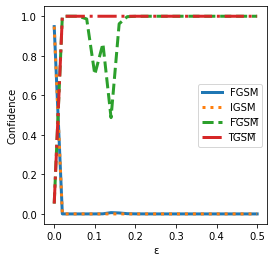

In [ ]:
plt.plot(epsilons, conf_fgsm, epsilons, conf_igsm, ':', epsilons, other_conf_fgsm, '--', epsilons, other_conf_igsm, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

L Infinite Top

Text(0, 0.5, 'Confidence')

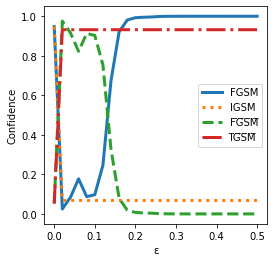

In [ ]:
plt.plot(epsilons, conf_fgsm_top, epsilons, conf_igsm_top, ':', epsilons, other_conf_fgsm_top, '--', epsilons, other_conf_igsm_top, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

L Infinite Bottom

Text(0, 0.5, 'Confidence')

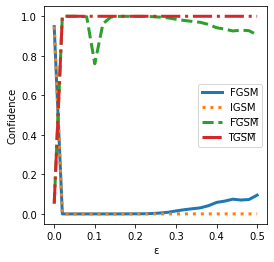

In [ ]:
plt.plot(epsilons, conf_fgsm_bottom, epsilons, conf_igsm_bottom, ':', epsilons, other_conf_fgsm_bottom, '--', epsilons, other_conf_igsm_bottom, '-.', linewidth=3)
plt.legend(['FGSM','IGSM',u'F\u0305G\u0305S\u0305M\u0305',u'I\u0305G\u0305S\u0305M\u0305'])
plt.xlabel(u'\u03B5')
plt.ylabel('Confidence')

#### Success rate of L Inifinite

In [ ]:
sum_fgsm_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_fgsm_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_fgsm_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_fgsm_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_fgsm_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_fgsm_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_igsm_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_igsm_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_igsm_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_igsm_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_igsm_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_igsm_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_correct_class = np.array([0.0,0,0,0,0,0,0,0,0,0])
n_test = len(x_test)

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#FGSM FULL
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_full[correct_class] += 1
      eps_fgsm_full[correct_class] += eps
      break
#IGSM FULL
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,correct_class,eps // 0.02,0.02, eps)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_full[correct_class] += 1
      eps_igsm_full[correct_class] += eps
      break
#FGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_top[correct_class] += 1
      eps_fgsm_top[correct_class] += eps
      break
#IGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,correct_class,eps // 0.02,0.02, eps, masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_top[correct_class] += 1
      eps_igsm_top[correct_class] += eps
      break
#FGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_fgsm_bottom[correct_class] += 1
      eps_fgsm_bottom[correct_class] += eps
      break
#IGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,correct_class,eps // 0.02,0.02, eps, masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      sum_igsm_bottom[correct_class] += 1
      eps_igsm_bottom[correct_class] += eps
      break

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
sr_fgsm_full = sum_fgsm_full / sum_correct_class
sr_fgsm_top = sum_fgsm_top / sum_correct_class
sr_fgsm_bottom = sum_fgsm_bottom / sum_correct_class

sr_igsm_full = sum_igsm_full / sum_correct_class
sr_igsm_top = sum_igsm_top / sum_correct_class
sr_igsm_bottom = sum_igsm_bottom / sum_correct_class

avg_eps_fgsm_full = eps_fgsm_full / sum_correct_class
avg_eps_igsm_full = eps_igsm_full / sum_correct_class

avg_eps_fgsm_top = eps_fgsm_top / sum_correct_class
avg_eps_igsm_top = eps_igsm_top / sum_correct_class

avg_eps_fgsm_bottom = eps_fgsm_bottom / sum_correct_class
avg_eps_igsm_bottom = eps_igsm_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of FGSM with full input: {:.2f}%'.format(sr_fgsm_full[i]*100))
  print('Success rate of FGSM with top input: {:.2f}%'.format(sr_fgsm_top[i]*100))
  print('Success rate of FGSM with bottom input: {:.2f}%'.format(sr_fgsm_bottom[i]*100))

  print('Success rate of IGSM with full input: {:.2f}%'.format(sr_igsm_full[i]*100))
  print('Success rate of IGSM with top input: {:.2f}%'.format(sr_igsm_top[i]*100))
  print('Success rate of IGSM with bottom input: {:.2f}%'.format(sr_igsm_bottom[i]*100))

  print('Average eps of FGSM with full input: {:.4f}'.format(avg_eps_fgsm_full[i]))
  print('Average eps of FGSM with top input: {:.4f}'.format(avg_eps_fgsm_top[i]))
  print('Average eps of FGSM with bottom input: {:.4f}'.format(avg_eps_fgsm_bottom[i]))

  print('Average eps of IGSM with full input: {:.4f}'.format(avg_eps_igsm_full[i]))
  print('Average eps of IGSM with top input: {:.4f}'.format(avg_eps_igsm_top[i]))
  print('Average eps of IGSM with bottom input: {:.4f}'.format(avg_eps_igsm_bottom[i]))



Class 0
All the data that is classified as its correct class: 17.0
Success rate of FGSM with full input: 100.00%
Success rate of FGSM with top input: 100.00%
Success rate of FGSM with bottom input: 100.00%
Success rate of IGSM with full input: 100.00%
Success rate of IGSM with top input: 100.00%
Success rate of IGSM with bottom input: 100.00%
Average eps of FGSM with full input: 0.0200
Average eps of FGSM with top input: 0.0235
Average eps of FGSM with bottom input: 0.0235
Average eps of IGSM with full input: 0.0200
Average eps of IGSM with top input: 0.0235
Average eps of IGSM with bottom input: 0.0212
Class 1
All the data that is classified as its correct class: 13.0
Success rate of FGSM with full input: 100.00%
Success rate of FGSM with top input: 38.46%
Success rate of FGSM with bottom input: 100.00%
Success rate of IGSM with full input: 100.00%
Success rate of IGSM with top input: 100.00%
Success rate of IGSM with bottom input: 100.00%
Average eps of FGSM with full input: 0.0215
A

In [ ]:
sum_sr_fgsm_full = sum(sum_fgsm_full) / sum(sum_correct_class)
sum_sr_fgsm_top = sum(sum_fgsm_top) / sum(sum_correct_class)
sum_sr_fgsm_bottom = sum(sum_fgsm_bottom) / sum(sum_correct_class)

sum_sr_igsm_full = sum(sum_igsm_full) / sum(sum_correct_class)
sum_sr_igsm_top = sum(sum_igsm_top) / sum(sum_correct_class)
sum_sr_igsm_bottom = sum(sum_igsm_bottom) / sum(sum_correct_class)

sum_avg_eps_fgsm_full = sum(eps_fgsm_full) / sum(sum_correct_class)
sum_avg_eps_igsm_full = sum(eps_igsm_full) / sum(sum_correct_class)

sum_avg_eps_fgsm_top = sum(eps_fgsm_top) / sum(sum_correct_class)
sum_avg_eps_igsm_top = sum(eps_igsm_top) / sum(sum_correct_class)

sum_avg_eps_fgsm_bottom = sum(eps_fgsm_bottom) / sum(sum_correct_class)
sum_avg_eps_igsm_bottom = sum(eps_igsm_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of FGSM with full input: {:.2f}%'.format(sum_sr_fgsm_full*100))
print('Success rate of FGSM with top input: {:.2f}%'.format(sum_sr_fgsm_top*100))
print('Success rate of FGSM with bottom input: {:.2f}%'.format(sum_sr_fgsm_bottom*100))

print('Success rate of IGSM with full input: {:.2f}%'.format(sum_sr_igsm_full*100))
print('Success rate of IGSM with top input: {:.2f}%'.format(sum_sr_igsm_top*100))
print('Success rate of IGSM with bottom input: {:.2f}%'.format(sum_sr_igsm_bottom*100))

print('Average eps of FGSM with full input: {:.4f}'.format(sum_avg_eps_fgsm_full))
print('Average eps of FGSM with top input: {:.4f}'.format(sum_avg_eps_fgsm_top))
print('Average eps of FGSM with bottom input: {:.4f}'.format(sum_avg_eps_fgsm_bottom))

print('Average eps of IGSM with full input: {:.4f}'.format(sum_avg_eps_igsm_full))
print('Average eps of IGSM with top input: {:.4f}'.format(sum_avg_eps_igsm_top))
print('Average eps of IGSM with bottom input: {:.4f}'.format(sum_avg_eps_igsm_bottom))

All the data that is classified as its correct class: 157.0
Success rate of FGSM with full input: 99.36%
Success rate of FGSM with top input: 93.63%
Success rate of FGSM with bottom input: 91.72%
Success rate of IGSM with full input: 99.36%
Success rate of IGSM with top input: 99.36%
Success rate of IGSM with bottom input: 99.36%
Average eps of FGSM with full input: 0.0208
Average eps of FGSM with top input: 0.0442
Average eps of FGSM with bottom input: 0.0397
Average eps of IGSM with full input: 0.0206
Average eps of IGSM with top input: 0.0280
Average eps of IGSM with bottom input: 0.0274


#### CW's success rate

In [ ]:
sum_cw_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_cw_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_cw_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_cw_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_cw_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_cw_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
c_cw_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_correct_class = np.array([0,0,0,0,0,0,0,0,0,0])

In [ ]:
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#CW FULL
  adv, eps, c = cw(image, correct_class, 50, 0.1)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_full[correct_class] += 1
    eps_cw_full[correct_class] += eps
    c_cw_full[correct_class] += c
#CW TOP
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_top[correct_class] += 1
    eps_cw_top[correct_class] += eps
    c_cw_top[correct_class] += c
#CW BOTTOM
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    sum_cw_bottom[correct_class] += 1
    eps_cw_bottom[correct_class] += eps
    c_cw_bottom[correct_class] += c

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
sr_cw_full = sum_cw_full / sum_correct_class
sr_cw_top = sum_cw_top / sum_correct_class
sr_cw_bottom = sum_cw_bottom / sum_correct_class

avg_eps_cw_full = eps_cw_full / sum_correct_class

avg_eps_cw_top = eps_cw_top / sum_correct_class

avg_eps_cw_bottom = eps_cw_bottom / sum_correct_class

avg_c_cw_full = c_cw_full / sum_correct_class

avg_c_cw_top = c_cw_top / sum_correct_class

avg_c_cw_bottom = c_cw_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of CW with full input: {:.2f}%'.format(sr_cw_full[i]*100))
  print('Success rate of CW with top input: {:.2f}%'.format(sr_cw_top[i]*100))
  print('Success rate of CW with bottom input: {:.2f}%'.format(sr_cw_bottom[i]*100))

  print('Average eps of CW with full input: {:.4f}'.format(avg_eps_cw_full[i]))
  print('Average eps of CW with top input: {:.4f}'.format(avg_eps_cw_top[i]))
  print('Average eps of CW with bottom input: {:.4f}'.format(avg_eps_cw_bottom[i]))

  print('Average c of CW with full input: {:.4f}'.format(avg_c_cw_full[i]))
  print('Average c of CW with top input: {:.4f}'.format(avg_c_cw_top[i]))
  print('Average c of CW with bottom input: {:.4f}'.format(avg_c_cw_bottom[i]))



Class 0
All the data that is classified as its correct class: 17
Success rate of CW with full input: 100.00%
Success rate of CW with top input: 100.00%
Success rate of CW with bottom input: 100.00%
Average eps of CW with full input: 0.0949
Average eps of CW with top input: 0.1600
Average eps of CW with bottom input: 0.1211
Average c of CW with full input: 0.0412
Average c of CW with top input: 0.0800
Average c of CW with bottom input: 0.0588
Class 1
All the data that is classified as its correct class: 13
Success rate of CW with full input: 100.00%
Success rate of CW with top input: 100.00%
Success rate of CW with bottom input: 100.00%
Average eps of CW with full input: 0.2014
Average eps of CW with top input: 0.4962
Average eps of CW with bottom input: 0.2519
Average c of CW with full input: 0.0385
Average c of CW with top input: 0.1477
Average c of CW with bottom input: 0.0569
Class 2
All the data that is classified as its correct class: 15
Success rate of CW with full input: 100.00%

In [ ]:
sum_sr_cw_full = sum(sum_cw_full) / sum(sum_correct_class)
sum_sr_cw_top = sum(sum_cw_top) / sum(sum_correct_class)
sum_sr_cw_bottom = sum(sum_cw_bottom) / sum(sum_correct_class)

sum_avg_eps_cw_full = sum(eps_cw_full) / sum(sum_correct_class)
sum_avg_eps_cw_top = sum(eps_cw_top) / sum(sum_correct_class)
sum_avg_eps_cw_bottom = sum(eps_cw_bottom) / sum(sum_correct_class)

sum_avg_c_cw_full = sum(c_cw_full) / sum(sum_correct_class)
sum_avg_c_cw_top = sum(c_cw_top) / sum(sum_correct_class)
sum_avg_c_cw_bottom = sum(c_cw_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of CW with full input: {:.2f}%'.format(sum_sr_cw_full*100))
print('Success rate of CW with top input: {:.2f}%'.format(sum_sr_cw_top*100))
print('Success rate of CW with bottom input: {:.2f}%'.format(sum_sr_cw_bottom*100))

print('Average eps of CW with full input: {:.4f}'.format(sum_avg_eps_cw_full))
print('Average eps of CW with top input: {:.4f}'.format(sum_avg_eps_cw_top))
print('Average eps of CW with bottom input: {:.4f}'.format(sum_avg_eps_cw_bottom))

print('Average c of CW with full input: {:.4f}'.format(sum_avg_c_cw_full))
print('Average c of CW with top input: {:.4f}'.format(sum_avg_c_cw_top))
print('Average c of CW with bottom input: {:.4f}'.format(sum_avg_c_cw_bottom))

All the data that is classified as its correct class: 157
Success rate of CW with full input: 100.00%
Success rate of CW with top input: 100.00%
Success rate of CW with bottom input: 100.00%
Average eps of CW with full input: 0.1186
Average eps of CW with top input: 0.1936
Average eps of CW with bottom input: 0.1697
Average c of CW with full input: 0.0301
Average c of CW with top input: 0.0594
Average c of CW with bottom input: 0.0525


#### JSMA's success rate

In [ ]:
sum_jsma_full = np.array([0,0,0,0,0,0,0,0,0,0])
sum_jsma_top = np.array([0,0,0,0,0,0,0,0,0,0])
sum_jsma_bottom = np.array([0,0,0,0,0,0,0,0,0,0])
eps_jsma_full = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_jsma_top = np.array([0.0,0,0,0,0,0,0,0,0,0])
eps_jsma_bottom = np.array([0.0,0,0,0,0,0,0,0,0,0])

sum_correct_class = np.array([0,0,0,0,0,0,0,0,0,0])

In [ ]:
for i in range(100):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  sum_correct_class[correct_class] += 1
  label = tf.reshape(y_test_oh[i], (1,10))
#JSMA FULL
  adv, eps = jsma(image,correct_class,220,0.5)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_full[correct_class] += 1
    eps_jsma_full[correct_class] += eps
#JSMA TOP
  adv, eps = jsma(image,correct_class,220,0.5, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_top[correct_class] += 1
    eps_jsma_top[correct_class] += eps
#JSMA BOTTOM
  adv, eps = jsma(image,correct_class,220,0.5, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    sum_jsma_bottom[correct_class] += 1
    eps_jsma_bottom[correct_class] += eps

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200


In [ ]:
sr_jsma_full = sum_jsma_full / sum_correct_class
sr_jsma_top = sum_jsma_top / sum_correct_class
sr_jsma_bottom = sum_jsma_bottom / sum_correct_class

avg_eps_jsma_full = eps_jsma_full / sum_correct_class

avg_eps_jsma_top = eps_jsma_top / sum_correct_class

avg_eps_jsma_bottom = eps_jsma_bottom / sum_correct_class

for i in range(10):
  print('Class {}'.format(i))
  print('All the data that is classified as its correct class: {}'.format(sum_correct_class[i]))
  print('Success rate of jsma with full input: {:.2f}%'.format(sr_jsma_full[i]*100))
  print('Success rate of jsma with top input: {:.2f}%'.format(sr_jsma_top[i]*100))
  print('Success rate of jsma with bottom input: {:.2f}%'.format(sr_jsma_bottom[i]*100))

  print('Average eps of jsma with full input: {:.4f}'.format(avg_eps_jsma_full[i]))
  print('Average eps of jsma with top input: {:.4f}'.format(avg_eps_jsma_top[i]))
  print('Average eps of jsma with bottom input: {:.4f}'.format(avg_eps_jsma_bottom[i]))

Class 0
All the data that is classified as its correct class: 9
Success rate of jsma with full input: 100.00%
Success rate of jsma with top input: 100.00%
Success rate of jsma with bottom input: 100.00%
Average eps of jsma with full input: 23.1111
Average eps of jsma with top input: 30.0000
Average eps of jsma with bottom input: 20.6667
Class 1
All the data that is classified as its correct class: 5
Success rate of jsma with full input: 100.00%
Success rate of jsma with top input: 80.00%
Success rate of jsma with bottom input: 100.00%
Average eps of jsma with full input: 15.4000
Average eps of jsma with top input: 34.8000
Average eps of jsma with bottom input: 16.6000
Class 2
All the data that is classified as its correct class: 5
Success rate of jsma with full input: 100.00%
Success rate of jsma with top input: 100.00%
Success rate of jsma with bottom input: 100.00%
Average eps of jsma with full input: 7.8000
Average eps of jsma with top input: 8.4000
Average eps of jsma with bottom i

In [ ]:
sum_sr_jsma_full = sum(sum_jsma_full) / sum(sum_correct_class)
sum_sr_jsma_top = sum(sum_jsma_top) / sum(sum_correct_class)
sum_sr_jsma_bottom = sum(sum_jsma_bottom) / sum(sum_correct_class)

sum_avg_eps_jsma_full = sum(eps_jsma_full) / sum(sum_correct_class)
sum_avg_eps_jsma_top = sum(eps_jsma_top) / sum(sum_correct_class)
sum_avg_eps_jsma_bottom = sum(eps_jsma_bottom) / sum(sum_correct_class)

print('All the data that is classified as its correct class: {}'.format(sum(sum_correct_class)))
print('Success rate of jsma with full input: {:.2f}%'.format(sum_sr_jsma_full*100))
print('Success rate of jsma with top input: {:.2f}%'.format(sum_sr_jsma_top*100))
print('Success rate of jsma with bottom input: {:.2f}%'.format(sum_sr_jsma_bottom*100))

print('Average eps of jsma with full input: {:.4f}'.format(sum_avg_eps_jsma_full))
print('Average eps of jsma with top input: {:.4f}'.format(sum_avg_eps_jsma_top))
print('Average eps of jsma with bottom input: {:.4f}'.format(sum_avg_eps_jsma_bottom))

All the data that is classified as its correct class: 78
Success rate of jsma with full input: 100.00%
Success rate of jsma with top input: 97.44%
Success rate of jsma with bottom input: 100.00%
Average eps of jsma with full input: 17.2821
Average eps of jsma with top input: 24.4359
Average eps of jsma with bottom input: 19.9359


## Heatmap for Sensitivity map

In [18]:
def jacobian_map(input_image, masked = None):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  gradient = []
  n_classes = len(z_cifar_classifier.predict(input_image)[0])
  for i in range(n_classes):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = z_cifar_classifier(input_image) 
      pred_inx = prediction[0][i]
    gradient.append((tf.cast(tape.gradient(pred_inx, input_image), tf.float32)*masked)[0])
  return gradient

def compute_clipped_map(image, s_map, high, low):
  image = tf.reshape(image, (h,w,ch))
  s_map = tf.reshape(s_map, (h,w,ch))
  c_map = np.zeros((h,w,ch))
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        dif = 0
        if (s_map[i][j][k] >= 0):
          dif = image[i][j][k]-low
        else:
          dif = high-image[i][j][k]
        c_map[i][j] = dif
  return tf.reshape(tf.cast(c_map,tf.float32), (h,w,ch))

def compute_other_s_map(s, target):
  sum_s_score = np.zeros((h,w,ch))
  for i in range(len(s)):
    if(i != target):
      temp_s_score = tf.reshape(s[i],(h,w,ch))
      sum_s_score += temp_s_score
  return tf.cast(sum_s_score, tf.float32)

def compute_cs_map(s_map, c_map, os_map):
  s_map = tf.reshape(s_map, (h,w,ch))
  c_map = tf.reshape(c_map, (h,w,ch))
  os_map = tf.reshape(os_map, (h,w,ch))
  ans = s_map*(os_map)*c_map
  return tf.abs(ans*tf.cast((ans <= 0), tf.float32))

def compute_sensitive_score(image, correct_inx, masked=None):
  if(masked == None):
    masked = tf.ones((1,h,w,ch))
  masked = tf.reshape(masked, (h,w,ch))
  s = jacobian_map(tf.reshape(image,(1,h,w,ch)))
  array_masked = [masked]*10
  s = s * np.array(array_masked)
  other_s_map = compute_other_s_map(s, correct_inx)
  image = tf.reshape(image, (h,w,ch))  
  s_map = tf.reshape(s[correct_inx],(h,w,ch))
  c_map = tf.reshape(compute_clipped_map(image, s_map, 1, 0), (h,w,ch))
  cs_map = compute_cs_map(s_map, c_map, other_s_map)
  sum_s = 0
  for i in range(h):
    for j in range(w):
      for k in range(ch):
        sum_s += tf.abs(cs_map[i][j][k])
  return sum_s

In [19]:
s = jacobian_map(tf.reshape(image,(1,h,w,ch)))
s_map = s[correct_inx]
c_map = compute_clipped_map(image, s_map,1,0)
os_map = compute_other_s_map(s, correct_inx)
cs_map = compute_cs_map(s_map, c_map, os_map)

In [20]:
cs_map2D = np.sum(cs_map, axis=2)

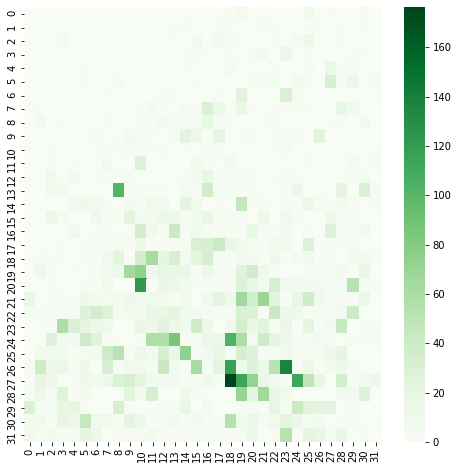

In [21]:
mpl.rcParams['figure.figsize'] = (8, 8)
ax = sns.heatmap(tf.reshape(cs_map2D, (h,w)), linewidth=0.0, cmap="Greens")
plt.show()
mpl.rcParams['figure.figsize'] = (4, 4)


In [ ]:
sum_s_top = compute_sensitive_score(image, correct_inx, masked_top)
sum_s_bottom = compute_sensitive_score(image, correct_inx, masked_bottom)

print(sum_s_top)
print(sum_s_bottom)

tf.Tensor(1432.7474, shape=(), dtype=float32)
tf.Tensor(6479.1743, shape=(), dtype=float32)


In [ ]:
num_images = []
for i in range(10):
  for j in range(200):
    inx = y_test[j]
    if (inx == i):
      num_images.append(x_test[j])
      break

Number: 0 
 S Score: 3546.830810546875
 S Score Top: 1365.3009033203125
 S Score Bottom: 2181.5302734375


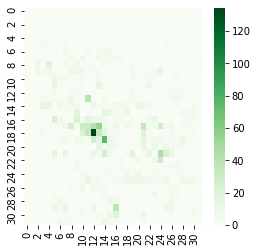

Number: 1 
 S Score: 7911.921875
 S Score Top: 1432.7474365234375
 S Score Bottom: 6479.17431640625


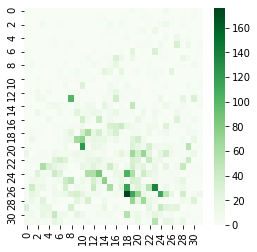

Number: 2 
 S Score: 6147.95703125
 S Score Top: 3032.821533203125
 S Score Bottom: 3115.1396484375


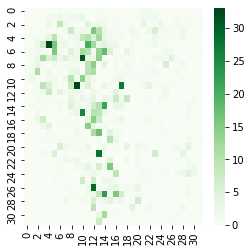

Number: 3 
 S Score: 3195.076416015625
 S Score Top: 2127.353271484375
 S Score Bottom: 1067.7266845703125


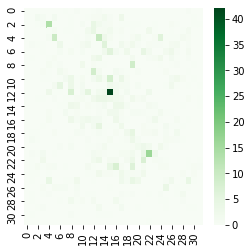

Number: 4 
 S Score: 12945.0908203125
 S Score Top: 5570.59375
 S Score Bottom: 7374.4658203125


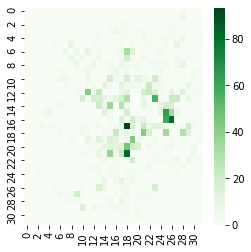

Number: 5 
 S Score: 8691.28515625
 S Score Top: 5373.09521484375
 S Score Bottom: 3318.1884765625


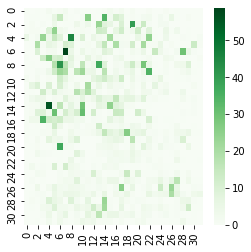

Number: 6 
 S Score: 6044.24072265625
 S Score Top: 2223.290771484375
 S Score Bottom: 3820.962646484375


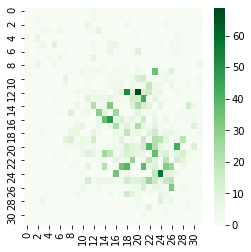

Number: 7 
 S Score: 3108.920654296875
 S Score Top: 1688.4183349609375
 S Score Bottom: 1420.505126953125


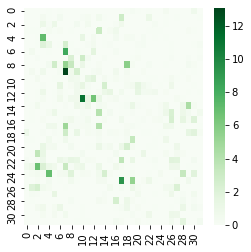

Number: 8 
 S Score: 11559.669921875
 S Score Top: 3158.031005859375
 S Score Bottom: 8401.634765625


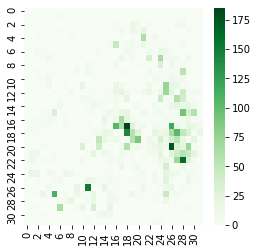

Number: 9 
 S Score: 14023.7333984375
 S Score Top: 3526.8408203125
 S Score Bottom: 10496.88671875


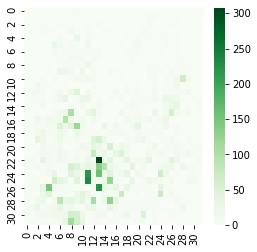

In [ ]:
for i in range(10):
  tmp_image = num_images[i]
  s_full = compute_sensitive_score(tmp_image, i)
  s_top = compute_sensitive_score(tmp_image, i, masked_top)
  s_bottom = compute_sensitive_score(tmp_image, i, masked_bottom)
  s = jacobian_map(tf.reshape(tmp_image,(1,h,w,ch)))
  c_map = compute_clipped_map(tmp_image, s[i], 1, 0)
  os_map = compute_other_s_map(s, correct_inx)
  s_map = s[i]
  cs_map = compute_cs_map(s_map, c_map, os_map)
  cs_map2D = np.sum(cs_map, axis=2)
  ax = sns.heatmap(tf.reshape(cs_map2D, (h,w)), linewidth=0.0, cmap="Greens")
  print('Number: {} \n S Score: {}\n S Score Top: {}\n S Score Bottom: {}'.format(i, s_full, s_top, s_bottom))
  plt.show()

In [ ]:
mean_s_full = [0,0,0,0,0,0,0,0,0,0]
mean_s_top = [0,0,0,0,0,0,0,0,0,0]
mean_s_bottom = [0,0,0,0,0,0,0,0,0,0]
num_count = [0, 0 ,0 ,0 ,0 ,0,0,0,0,0]
for i in range(200):
  print('{}/200'.format(i+1))
  num = y_test[i]   
  tmp_image = x_test[i]
  tmp_image = tf.reshape(tmp_image, (1,h,w,ch))
  pred, _ = get_class_confidence(tmp_image)
  if(pred == tf.cast(num, tf.int64)):
    num_count[num] += 1    
    s_full = compute_sensitive_score(tmp_image, num)
    s_top = compute_sensitive_score(tmp_image, num, masked_top)
    s_bottom = compute_sensitive_score(tmp_image, num, masked_bottom)
    mean_s_full[num] += s_full
    mean_s_top[num] += s_top
    mean_s_bottom[num] += s_bottom  

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
mean_s_full = np.array(mean_s_full)
mean_s_top = np.array(mean_s_top)
mean_s_bottom = np.array(mean_s_bottom)
num_count = np.array(num_count)

mean_s_full = mean_s_full/num_count
mean_s_top = mean_s_top/num_count
mean_s_bottom = mean_s_bottom/num_count

In [ ]:
for i in range(10):
  print('Number: {}\nMean S Score: {}\nMean S Score Top: {}\nMean S Score Bottom: {}'.format(i
                                                                                             , mean_s_full[i]
                                                                                             , mean_s_top[i]
                                                                                             , mean_s_bottom[i]))

Number: 0
Mean S Score: 3532.1185661764707
Mean S Score Top: 1556.444393382353
Mean S Score Bottom: 1975.674862132353
Number: 1
Mean S Score: 15098.723557692309
Mean S Score Top: 3800.129206730769
Mean S Score Bottom: 11298.588942307691
Number: 2
Mean S Score: 6987.288020833334
Mean S Score Top: 3930.027864583333
Mean S Score Bottom: 3057.2643229166665
Number: 3
Mean S Score: 5165.944010416667
Mean S Score Top: 2952.3509114583335
Mean S Score Bottom: 2213.5921223958335
Number: 4
Mean S Score: 11001.480902777777
Mean S Score Top: 5583.1015625
Mean S Score Bottom: 5418.373697916667
Number: 5
Mean S Score: 13227.042410714286
Mean S Score Top: 8088.258370535715
Mean S Score Bottom: 5138.786830357143
Number: 6
Mean S Score: 10897.975142045454
Mean S Score Top: 6387.649147727273
Mean S Score Bottom: 4510.327059659091
Number: 7
Mean S Score: 5163.533528645833
Mean S Score Top: 2638.0284830729165
Mean S Score Bottom: 2525.5035807291665
Number: 8
Mean S Score: 12973.622395833334
Mean S Score To

## Individual-image basis Accuracy

In [ ]:
fgsm_correct = 0
igsm_correct = 0
cw_correct = 0
jsma_correct = 0

n_fgsm = 0
n_igsm = 0
n_cw = 0
n_jsma = 0

### FGSM and IGSM

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10))
  fgsm_eps_top = 0.55
  fgsm_eps_bottom = 0.55
  igsm_eps_top = 0.55
  igsm_eps_bottom = 0.55
#FGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      fgsm_eps_top = eps
      break
#IGSM TOP
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_top)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      igsm_eps_top = eps
      break
#FGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = fgsm(image,label,eps,masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      fgsm_eps_bottom = eps
      break
#IGSM BOTTOM
  for j, eps in enumerate(epsilons_no_zero):
    adv = igsm(image,label,eps // 0.02,0.02, eps, masked_bottom)
    new_class, _ = get_class_confidence(adv)
    if(correct_class != new_class):
      igsm_eps_bottom = eps
      break
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((fgsm_eps_top > fgsm_eps_bottom and s_top < s_bottom) or (fgsm_eps_top < fgsm_eps_bottom and s_top > s_bottom)):
    fgsm_correct += 1
    n_fgsm += 1
  elif (fgsm_eps_top != fgsm_eps_bottom):
    n_fgsm += 1
  if ((igsm_eps_top > igsm_eps_bottom and s_top < s_bottom) or (igsm_eps_top < igsm_eps_bottom and s_top > s_bottom)):
    igsm_correct += 1
    n_igsm += 1
  elif (igsm_eps_top != igsm_eps_bottom):
    n_igsm += 1

fgsm_acc = fgsm_correct/float(n_fgsm)
igsm_acc = igsm_correct/float(n_igsm)
print('Correct FGSM: {}\nAccuracy FGSM: {}\nCorrect IGSM: {}\nAccuracy IGSM: {}\n'.format(fgsm_correct,fgsm_acc*100,igsm_correct,igsm_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
print(n_fgsm)
print(n_igsm)

59
59


### CW Attack

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10))
  cw_eps_top = 11
  cw_eps_bottom = 11
#CW TOP
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    cw_eps_top = eps
#CW BOTTOM
  adv, eps, c = cw(image, correct_class, 50, 0.1, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= 10):
    cw_eps_bottom = eps
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((cw_eps_top > cw_eps_bottom and s_top < s_bottom) or (cw_eps_top < cw_eps_bottom and s_top > s_bottom)):
    cw_correct += 1
    n_cw += 1
  elif (cw_eps_top != cw_eps_bottom):
    n_cw += 1  

cw_acc = cw_correct/float(n_cw)
print('Correct CW: {}\nAccuracy CW: {}'.format(cw_correct,cw_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
print(n_cw)

157


### JSMA

In [ ]:
epsilons_no_zero = epsilons[1:]
for i in range(200):
  print('{}/{}'.format(i+1,200))
  image = x_test[i]
  correct_class = tf.cast(y_test[i], tf.int64)
  pred, _ = get_class_confidence(image)
  if(correct_class != pred):
    continue
  label = tf.reshape(y_test_oh[i], (1,10)) 
  jsma_eps_top = h*w*ch*0.05 + 1
  jsma_eps_bottom = h*w*ch*0.05 + 1
#JSMA TOP
  adv, eps = jsma(image,correct_class,220,0.5, masked=masked_top)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    jsma_eps_top = eps
#JSMA BOTTOM
  adv, eps = jsma(image,correct_class,220,0.5, masked=masked_bottom)
  new_class, _ = get_class_confidence(adv)
  if(correct_class != new_class and eps <= h*w*ch*0.05):
    jsma_eps_bottom = eps
  s_top = compute_sensitive_score(image, correct_class, masked_top)
  s_bottom = compute_sensitive_score(image, correct_class, masked_bottom)
  if ((jsma_eps_top > jsma_eps_bottom and s_top < s_bottom) or (jsma_eps_top < jsma_eps_bottom and s_top > s_bottom)):
    jsma_correct += 1
    n_jsma += 1
  elif (jsma_eps_top != jsma_eps_bottom):
    n_jsma += 1  
  print("{} and {}".format(jsma_correct,n_jsma))

jsma_acc = jsma_correct/float(n_jsma)
print('Correct JSMA: {}\nAccuracy JSMA: {}'.format(jsma_correct,jsma_acc*100))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
59 and 76
106/200
60 and 77
107/200
61 and 78
108/200
62 and 79
109/200
63 and 80
110/200
64 and 81
111/200
64 and 82
112/200
65 and 83
113/200
66 and 84
114/200
66 and 85
115/200
66 and 86
116/200
66 and 87
117/200
67 and 88
118/200
68 and 89
119/200
69 and 90
120/20